- Name: `dissipation-theory--Study-26.ipynb`
- Author: John A. Marohn
- Date: 2024-10-12
- Continued from: `dissipation-theory--Study-25.ipynb`
- Continued to: ---
- Summary: Redo `Study 25` using new python code implementing Loring's clean, revised equations for the BLDS frequency shift.

Loring's clear, revised equations are writtien in terms of a new unitless integral $K$, not a correlation function $C$ (Leakkala) or a response function $R$ (Marohn).  The code in `dissipation.py` and `dissipation2.py` writes the friction and BLDS frequency shift in terms of a correlation function $C$ introduced in Leakkala's 2013 *JCP* paper.  In `dissipation3.py` I rewrite the `dissipation.py` code in terms of Loring's unitless $K$ integral, elimating extranneous factors of $k_{\mathrm{b}} T$.  In `dissipation3.py` I follow the convention of `dissipation2.py`, where the sample's dependent variables are conductivity $\sigma$ and charge denstiy $\rho$, not the convention in `dissipation.py`, where the sample's dependent variable are conductivity $\sigma$ and mobility $\mu$.

# Preliminaries

In [1]:
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [3]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation3 import CantileverModel, SampleModel1, theta1norm
from dissipationtheory.dissipation3 import gamma_perpendicular, blds_perpendicular
from dissipationtheory.dissipation3 import BLDSlimits, BLDSapprox

In [4]:
THIS = 'dissipation-theory--Study-26--'
fig = {}

# Define the cantilever and the sample

Set up the cantilever and sample to be the same as in `Study 25`.  We are going to run a `Model 1` calculation.  To avoid extra worries baout units, do the calculations in regular Python, not `jit`, to start.

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'), 
    d = ureg.Quantity(38, 'nm')
)

In [6]:
cantilever

cantilever

      resonance freq = 75.000 kHz
                     = 4.712e+05 rad/s
     spring constant = 2.800 N/m
  tip-sample voltage = 1.000 V
              radius = 35.000 nm
              height = 38.000 nm

In [7]:
sample = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(500, 'nm'),
    epsilon_s = ureg.Quantity(complex(20, -0.2), ''),
    sigma = ureg.Quantity(1E-5, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(300, 'nm')
)

In [8]:
sample

cantilever

      resonance freq = 75.000 kHz
                     = 4.712e+05 rad/s
     spring constant = 2.800 N/m
  tip-sample voltage = 1.000 V
              radius = 35.000 nm
              height = 38.000 nm

semiconductor

             epsilon (real) = 20.000
             epsilon (imag) = -0.200
                  thickness = 500.0 nm
               conductivity = 1.000e-05 S/m
             charge density = 1.000e+21 m^{-3}
           reference height = 3.000e+02 nm

         roll-off frequency = 1.129e+06 Hz
                   mobility = 6.242e-08 m^2/(V s)
         diffusion constant = 1.614e-09 m^2/s
               Debye length = 3.780e+01 nm
           diffusion length = 5.852e+01 nm
   effective epsilon (real) = 20.000
   effective epsilon (imag) = -2.597

dielectric

  epsilon (real) = 1000000.000
  epsilon (imag) = 0.000
       thickness = infinite

# Trial calculations of friction and BLDS frequency shift (Python, slow)

Check that both calculations work, and return an answer with the appropriate units.

The function `gamma_perpendicular` returns a three-element array, with units.  The array elements are the three terms contributing to the total friction.

In [9]:
ans1 = gamma_perpendicular(theta1norm, sample)
ans1 

Magnitude,[3.935960284420396 2.071704823856406 0.5163580638291028]
Units,piconewton second/meter


Sum the array to get the total friction.

In [10]:
ans1.sum(axis=0)

<Quantity(6.524023172105904, 'piconewton * second / meter')>

The function `blds_perpendicular` return an array of arrays.  The second array is a three-element array, with units, the array elements are teh three terms contributing to the BLDS frequency shift.

In [11]:
omega_m = ureg.Quantity(2 * np.pi * np.logspace(1, 3, 2), 'Hz')
ans2 = blds_perpendicular(theta1norm, sample, omega_m)
ans2

Magnitude,[[-6.201884478545333 -1.9086751902497232 -2.807472692370203] [-6.201846107846846 -1.9085112168230167 -2.8049998983659523]]
Units,hertz


Sum over the 1st axis to get total BLDS frequency shift.

In [12]:
ans2.sum(axis=1)

Magnitude,[-10.918032361165258 -10.915357223035816]
Units,hertz


Both answers have the right units, yea!

# Create list of modulation frequencies and charge densities

Set up arrays of modulation frequency $\omega_{\mathrm{m}}$ and conductivity $\sigma$.

In [13]:
N_omega = 5
N_sigma = 20

In [14]:
omega_m = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=N_omega), 'Hz')

In [15]:
sigma = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-9),
        stop=np.log10(1),
        num=N_sigma), 'S/m')

# Test Loring's BLDS spectrum limits

Loring's expansion is for the 1st term only.

In [16]:
def plotBLDSapprox(sample):

    x_temp = np.logspace(-3, 2, 40)
    BLDS_low, BLDS_high = BLDSlimits(sample, x_temp)
    x_sub, BLDS_sub = BLDSapprox(sample, x_temp)
    
    fig = plt.figure(figsize=(3.5, 2.5))
    
    plt.semilogx(x_temp, BLDS_low.to('Hz').magnitude, 'k--')
    plt.semilogx(x_temp, BLDS_high.to('Hz').magnitude, 'k-.')
    plt.semilogx(x_sub, BLDS_sub.to('Hz').magnitude,'-')
    
    plt.xlabel(r'$(h / \lambda_{\mathrm{D}})^2$')
    plt.ylabel(r'|$\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)$| [Hz]')

    plt.tight_layout()
    plt.show()
    
    return fig

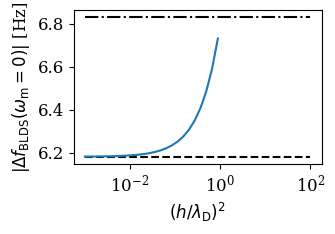

In [17]:
fig['01'] = plotBLDSapprox(sample)

# Loop over densities and create a spectrum

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  

In [18]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 

As we vary $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.

In [19]:
rho = (sigma / (qe * mu)).to('1/m^3')

Get ready to run the simulations.

In [20]:
data = {}        # many simulations
data['01'] = {}  # the first simulation

Run the simulations.  This loop takes many, many minutes because we are running the calculations in Python, not `jit`.

In [21]:
# remember
sigma0 = sample.sigma
rho0 =  sample.rho

# set
for rho_, sigma_ in zip(rho, sigma):

    print('rho = {:0.1e}/m^3'.format(rho_.to('1/m^3').magnitude))
    sample.rho = rho_
    sample.sigma = sigma_

    gamma = gamma_perpendicular(theta1norm, sample).to('pN s/m')
    f_BLDS = blds_perpendicular(theta1norm, sample, omega_m).to('Hz')
    
    data['01'][str(sigma_.to('S/m').magnitude)] = {
        'omega_m': omega_m,
        'f_BLDS': f_BLDS, 
        'gamma': gamma,
        'sigma': sample.sigma.to('S/m'),
        'd': sample.cantilever.d.to('m'),
        'rho': sample.rho.to('1/m^3'),
        'LD': sample.LD.to('m'),
        'omega_c': sample.cantilever.omega_c.to('Hz'),
        'omega_0': (sample.sigma.to('S/m')/epsilon0).to('Hz')}

# reset
sample.rho = rho0
sample.sigma = sigma0

rho = 6.2e+17/m^3
rho = 1.9e+18/m^3
rho = 5.5e+18/m^3
rho = 1.6e+19/m^3
rho = 4.9e+19/m^3
rho = 1.5e+20/m^3
rho = 4.3e+20/m^3
rho = 1.3e+21/m^3
rho = 3.8e+21/m^3
rho = 1.1e+22/m^3
rho = 3.4e+22/m^3
rho = 1.0e+23/m^3
rho = 3.0e+23/m^3
rho = 9.0e+23/m^3
rho = 2.7e+24/m^3
rho = 8.0e+24/m^3
rho = 2.4e+25/m^3
rho = 7.0e+25/m^3
rho = 2.1e+26/m^3
rho = 6.2e+26/m^3


From `Study 25`, a helper function to plot the BLDS spectra.  Make sure to add up the three terms to get the total BLDS frequency shift.

In [22]:
def plotBLDS(data):

    rho = np.zeros(len(data))    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude

    # colormap = plt.cm.jet
    colormap = plt.cm.magma_r
    color_list = [colormap(i) for i in np.linspace(0, 1, len(data))]

    normalized_colors = mcolors.LogNorm(vmin=min(rho), vmax=max(rho))
    scalar_mappable = cm.ScalarMappable(norm=normalized_colors, cmap=colormap)
    scalar_mappable.set_array(len(color_list))
    
    fig, ax = plt.subplots(figsize=(4.5, 3))
    for index, key in enumerate(data.keys()):
        
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(
                data[key]['omega_m'].to('Hz').magnitude,
                np.abs(data[key]['f_BLDS'].sum(axis=1).to('Hz').magnitude),
                '-',
                color=color_list[index])

    # color bar
    clb=plt.colorbar(scalar_mappable, ax=ax)
    clb.ax.set_title(r'$\rho \: [\mathrm{cm}^{-3}]$', fontsize=12)
    
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('mod. freq. $\omega_{\mathrm{m}}$ [rad/s]')
    plt.tight_layout()
    plt.show()
    
    return fig

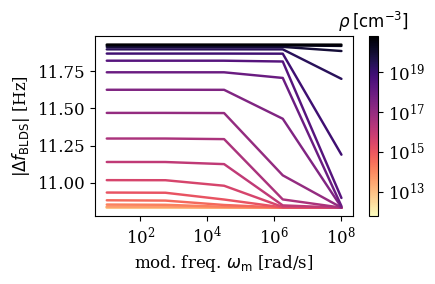

In [23]:
fig['02'] = plotBLDS(data['01'])

From `Study 25`, another helper function.  This one plots the low-frequency BLDS spectrum and the friction versus charge density and two unitless variables.

Make another low-density approximation for the zero-frequency BLDS shift.  I think Loring has an extra factor of $\epsilon_{\mathrm{s}}^{\prime}$ in linear term; write a corrected function.

In [24]:
from dissipationtheory.dissipation3 import BLDSpre

def BLDSapprox2(sample, x):

    pre = BLDSpre(sample)
    _, BLDS_high = BLDSlimits(sample, x)
    
    er = sample.epsilon_s.real.magnitude
    a = 0.25 * (er - 1)/(er + 1)
    b = 0.50 / (er + 1)**2

    BLDS_approx = pre * (a + b * x)
    mask = BLDS_approx.to('Hz').magnitude <= 1.10 * BLDS_high.to('Hz').magnitude
    
    return [x[mask], BLDS_approx[mask]]

In [25]:
def plotme(data):

    # Loop over the data and gather up the charge density, Debye length, cantilever height,
    # friction and BLDS frequency shift at the lowest modulation frequency (approximating
    # the zero-frequency limit)
    
    rho = np.zeros(len(data))
    LD = np.zeros(len(data))
    d = np.zeros(len(data))
    gamma = np.zeros((len(data),3))
    blds0 = np.zeros((len(data),3))
    omega_0 = np.zeros(len(data))
    omega_c = np.zeros(len(data))
    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude
        LD[index] = data[key]['LD'].to('m').magnitude
        d[index] = data[key]['d'].to('m').magnitude
        gamma[index] = data[key]['gamma'].to('pN s/m').magnitude
        blds0[index] = np.abs(data[key]['f_BLDS'][0,:].to('Hz').magnitude)
        omega_0[index] = data[key]['omega_0'].to('Hz').magnitude
        omega_c[index] = data[key]['omega_c'].to('Hz').magnitude
    
    # (Left hand plot) 
    # Make the x-axis the unitless ratio of the height to Debye length squared,
    # which is proportional to charge density.

    xL = (d/LD)**2
    rho0L = (rho/xL)[0]

    # Define functions to convert from xL to rho and back again
    
    def fwdL(xL):
        return xL*rho0L

    def revL(rho):
        return rho/rho0L

    # (Right hand plot)
    # Make the x-axis the unitless ratio of omega_0 to omega_c, which
    # is proportional to conductivity and therefore charge density

    xR = omega_0/(sample.epsilon_s.real.magnitude * omega_c)
    rho0R = (rho/xR)[0]
    
    # Define functions to convert from xR to rho and back again

    def fwdR(xR):
        return xR*rho0R

    def revR(rho):
        return rho/rho0R
    
    # Now make the nice plot
    
    fig, ax = plt.subplots(1, 2, figsize=(7.5, 5))
    
    ax2L = ax[0].secondary_xaxis("top", functions=(fwdL,revL))
    ax2R = ax[1].secondary_xaxis("top", functions=(fwdR,revR))

    BLDS_low, BLDS_high = BLDSlimits(sample, xL)
    xL_sub_A, BLDS_sub_A = BLDSapprox(sample, xL)
    xL_sub_B, BLDS_sub_B = BLDSapprox2(sample, xL)

    with plt.style.context('seaborn-v0_8'):
        ax[0].semilogx(xL, BLDS_low.to('Hz').magnitude, 'k--')
        ax[0].semilogx(xL, BLDS_high.to('Hz').magnitude, 'k-.')
        ax[0].semilogx(xL_sub_A, BLDS_sub_A.to('Hz').magnitude,'k-', label='RL approx')
        ax[0].semilogx(xL_sub_B, BLDS_sub_B.to('Hz').magnitude,'k:', label='JM approx')  
        ax[0].semilogx(xL, blds0, '-', label=['$K_2$','$K_1$','$K_0$'])
        ax[1].semilogx(xR, gamma, '-', label=['$K_2$','$K_1$','$K_0$'])
        
    ax[0].set_xlabel(r'$(h / \lambda_{\mathrm{D}})^2$')
    ax[0].set_ylabel(r'|$\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)$| [Hz]')
    ax[0].legend(fontsize=9)
    ax[0].grid()
    ax[1].grid()
    
    ax[1].set_xlabel(r'$\omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$')
    ax[1].set_ylabel(r'$\gamma_{\perp}$ [pN s/m]')
    ax[1].legend(fontsize=9)
    
    ax2L.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    ax2R.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    
    plt.tight_layout()
    plt.show()
    
    return fig

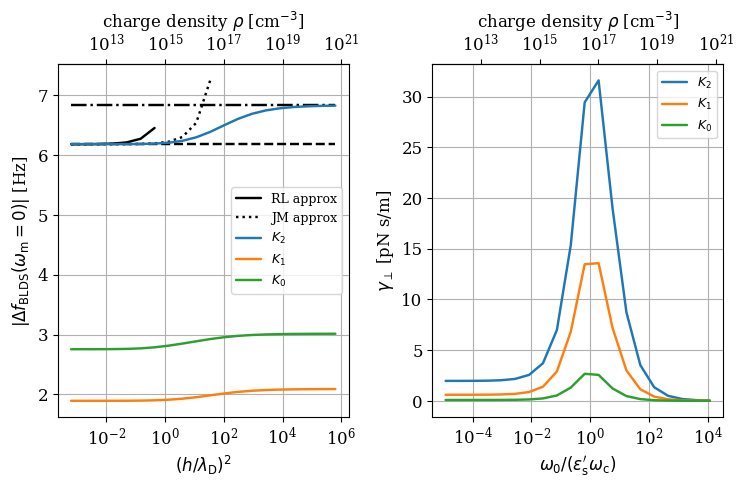

In [26]:
fig['03'] = plotme(data['01'])

# Save all figures

In [27]:
if 1:
    for num in fig.keys():
        figname = THIS + "Fig-" + num
        fig[num].savefig(figname + '.png', dpi=300)
        fig[num].savefig(figname + '.pdf')